![](https://media.sproutsocial.com/uploads/2019/03/sentiment-analysis.svg "credit: https://sproutsocial.com/insights/social-media-sentiment-analysis/")


# Libraires & Configuration

### Check GPU

In [1]:
!nvidia-smi

Fri Nov 12 14:26:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Libraries 

In [2]:
%%capture
!pip install tensorflow_text
# !pip install bokeh
# !pip install simpleneighbors[annoy]
!pip install tqdm

In [3]:
import os 

# session crash issue
# https://stackoverflow.com/a/54927279/11105356

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Load HUB Model
---
**USE(Universal Sentence Encoder)**

In [6]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

### Sample Example

In [41]:
txt_1 = ["the bedroom is cozy"]
txt_2 = ["comfortable bedroom"]

In [43]:
emb_1 = use(txt_1)
emb_2 = use(txt_2)

In [44]:
print(emb_1.shape)

(1, 512)


#### Correlation

In [45]:
print(np.inner(emb_1, emb_2).flatten()[0])

0.8467272


# Load Dataset
---
Dataset Source :

[jiashenliu/515k-hotel-reviews-data-in-europe](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe)

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe

 73% 33.0M/45.1M [00:00<00:00, 58.0MB/s]
100% 45.1M/45.1M [00:00<00:00, 91.7MB/s]


In [4]:
!unzip /content/515k-hotel-reviews-data-in-europe.zip

Archive:  /content/515k-hotel-reviews-data-in-europe.zip
  inflating: Hotel_Reviews.csv       


# EDA

In [5]:
df_hotel_reviews = pd.read_csv("/content/Hotel_Reviews.csv")
df_hotel_reviews.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [ ]:
f"{df_hotel_reviews.shape[0]} rows, {df_hotel_reviews.shape[1]} columns"

'515738 rows, 17 columns'

In [ ]:
df_hotel_reviews.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [ ]:
df_hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [ ]:
df_hotel_reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
Additional_Number_of_Scoring,515738.0,498.081836,500.538467,1.000000,169.000000,341.000000,660.000000,2682.000000
Average_Score,515738.0,8.397487,0.548048,5.200000,8.100000,8.400000,8.800000,9.800000
Review_Total_Negative_Word_Counts,515738.0,18.539450,29.690831,0.000000,2.000000,9.000000,23.000000,408.000000
Total_Number_of_Reviews,515738.0,2743.743944,2317.464868,43.000000,1161.000000,2134.000000,3613.000000,16670.000000
Review_Total_Positive_Word_Counts,515738.0,17.776458,21.804185,0.000000,5.000000,11.000000,22.000000,395.000000
Total_Number_of_Reviews_Reviewer_Has_Given,515738.0,7.166001,11.040228,1.000000,1.000000,3.000000,8.000000,355.000000
Reviewer_Score,515738.0,8.395077,1.637856,2.500000,7.500000,8.800000,9.600000,10.000000
lat,512470.0,49.442439,3.466325,41.328376,48.214662,51.499981,51.516288,52.400181
lng,512470.0,2.823803,4.579425,-0.369758,-0.143372,0.010607,4.834443,16.429233


In [ ]:
df_hotel_reviews.describe(include='object').T

,count,unique,top,freq
Hotel_Address,515738,1493,163 Marsh Wall Docklands Tower Hamlets London ...,4789
Review_Date,515738,731,8/2/2017,2585
Hotel_Name,515738,1492,Britannia International Hotel Canary Wharf,4789
Reviewer_Nationality,515738,227,United Kingdom,245246
Negative_Review,515738,330011,No Negative,127890
Positive_Review,515738,412601,No Positive,35946
Tags,515738,55242,"[' Leisure trip ', ' Couple ', ' Double Room '...",5101
days_since_review,515738,731,1 days,2585


In [ ]:
df_hotel_reviews.Reviewer_Score.describe().T

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

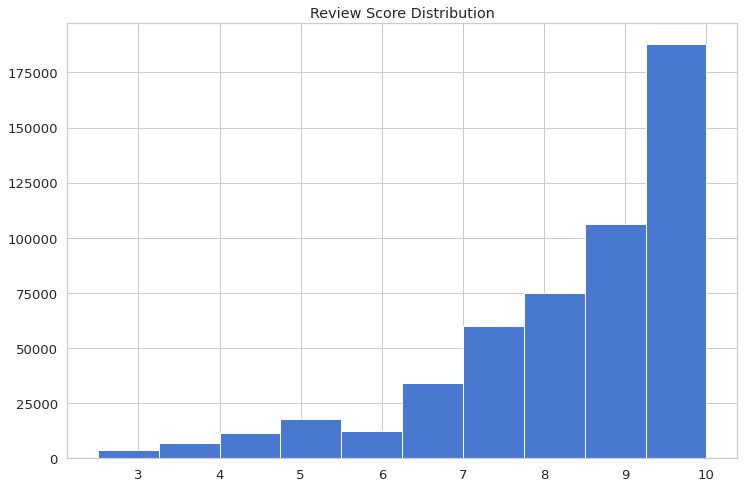

In [6]:
df_hotel_reviews.Reviewer_Score.hist()
plt.title('Review Score Distribution');

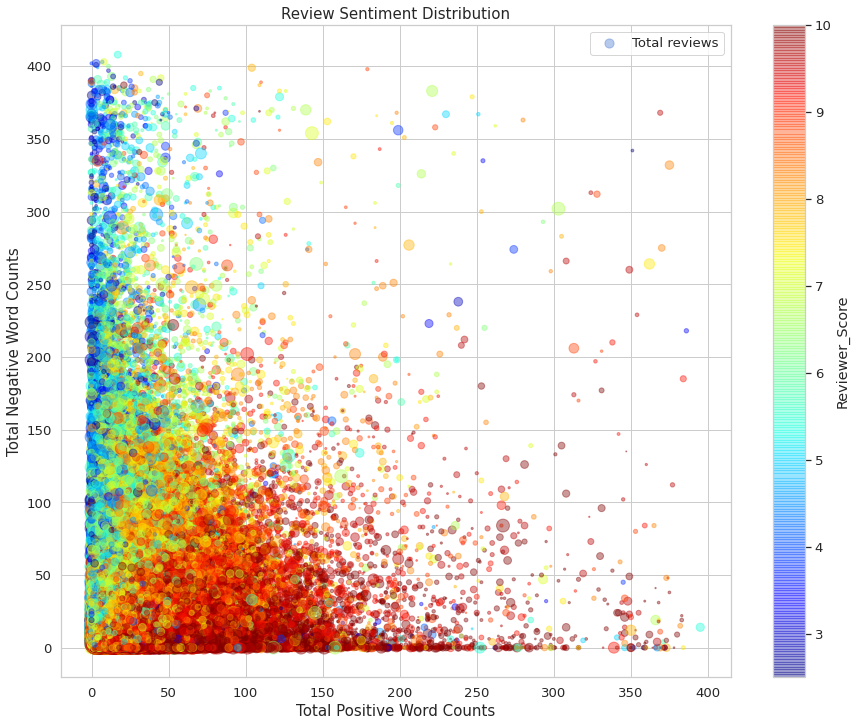

In [ ]:
df_hotel_reviews.plot(kind='scatter', 
                      x='Review_Total_Positive_Word_Counts', 
                      y='Review_Total_Negative_Word_Counts', 
                      label='Total reviews',
             s=df_hotel_reviews.Total_Number_of_Reviews/100,
             c='Reviewer_Score',
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(15,12),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Sentiment Distribution",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()

In [ ]:
df_hotel_reviews.Reviewer_Nationality.value_counts()[:20]

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
Name: Reviewer_Nationality, dtype: int64

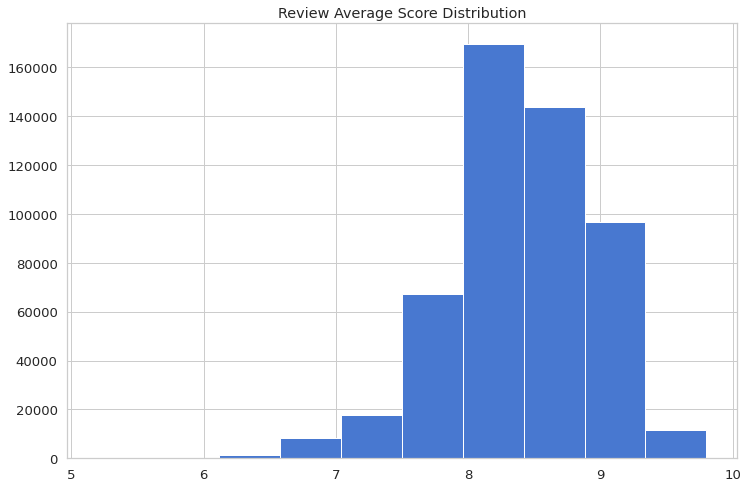

In [7]:
df_hotel_reviews.Average_Score.hist()
plt.title('Review Average Score Distribution');

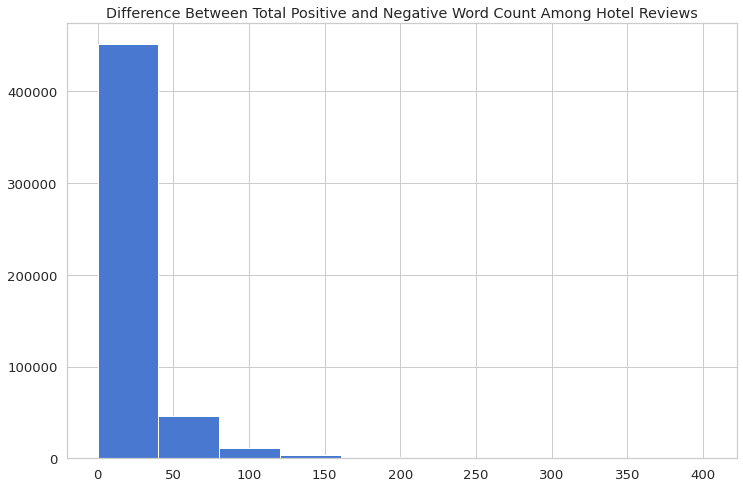

In [8]:
abs(df_hotel_reviews.Review_Total_Positive_Word_Counts - df_hotel_reviews.Review_Total_Negative_Word_Counts).hist()
plt.title('Difference Between Total Positive and Negative Word Count Among Hotel Reviews');

### Cleaning Review Text

In [ ]:
df_hotel_reviews['Negative_Review'][1]

'No Negative'

In [ ]:
df_hotel_reviews.loc[:, 'Positive_Review'] = df_hotel_reviews.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df_hotel_reviews.loc[:, 'Negative_Review'] = df_hotel_reviews.Negative_Review.apply(lambda x: x.replace('No Negative', ''))

In [ ]:
df_hotel_reviews['Negative_Review'][1]

''

### Merged Feature (Both Review Text)

In [ ]:
df_hotel_reviews['review'] = df_hotel_reviews.Positive_Review + df_hotel_reviews.Negative_Review

## Set Sentiment Type

In [ ]:
df_hotel_reviews["review_type"] = df_hotel_reviews["Reviewer_Score"].apply(
    lambda x: "bad" if x < 7 else "good")

In [ ]:
df_reviews = df_hotel_reviews[["review", "review_type"]]

In [ ]:
df_reviews

,review,review_type
0,Only the park outside of the hotel was beauti...,bad
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,bad
...,...,...
515733,location no trolly or staff to help you take ...,good
515734,Breakfast was ok and we got earlier check in ...,bad
515735,The ac was useless It was a hot week in vienn...,bad
515736,The rooms are enormous and really comfortable...,good


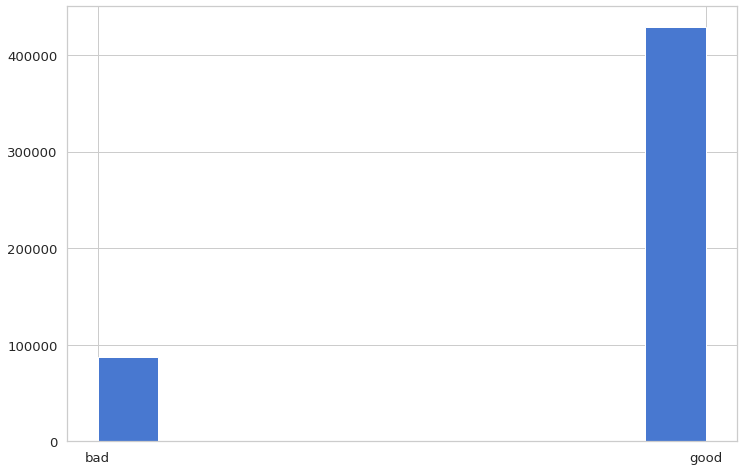

In [ ]:
df_reviews.review_type.hist();
# imbalanced distribution

In [ ]:
df_reviews[df_reviews.review_type == 'good'].review.value_counts()

 Location                                                                                                                                                                                                                                              947
 Everything Nothing                                                                                                                                                                                                                                    938
 Everything                                                                                                                                                                                                                                            599
 Great location                                                                                                                                                                                                                                        

In [ ]:
df_reviews[df_reviews.review_type == 'bad'].review.value_counts()

 Nothing Everything                                                                                                                                                                                                                                                                                                     124
 Location                                                                                                                                                                                                                                                                                                               107
 Nothing                                                                                                                                                                                                                                                                                                                 36
 location                                           

In [ ]:
good_reviews = df_reviews[df_reviews.review_type == "good"]
bad_reviews = df_reviews[df_reviews.review_type == "bad"]

In [ ]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

## Word Cloud

In [ ]:
# generate Word Cloud
def gen_wc(txt):
  stopwords = set(STOPWORDS) 

  # crisp wordcloud : https://stackoverflow.com/a/28795577/11105356
  wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
  plt.figure(figsize=(14,10))
  plt.imshow(wc, interpolation="bilinear")
  plt.axis('off')
  plt.show()

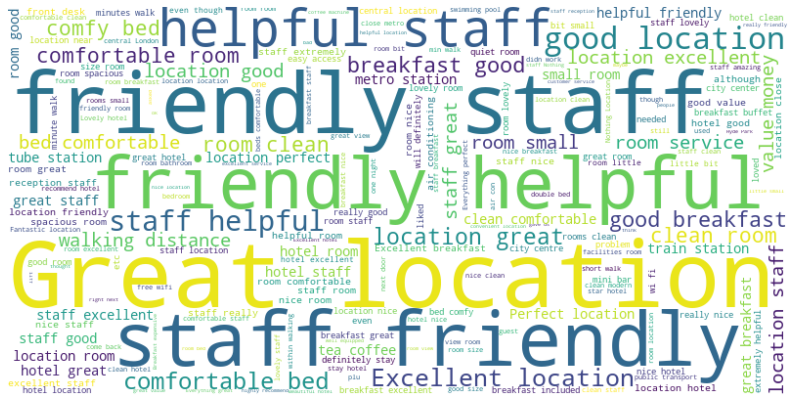

In [ ]:
gen_wc(good_reviews_text)

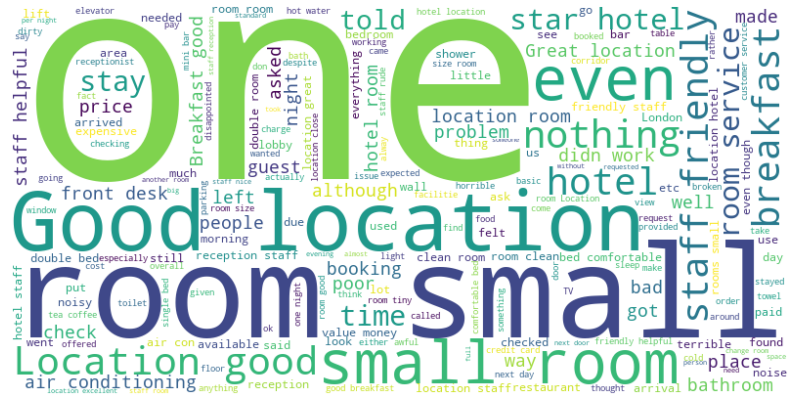

In [ ]:
gen_wc(bad_reviews_text)

## Resample Dataset

Under sample the positive review to achieve a balanced distribution between reviews

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)

df_review_resampled = good_df.append(bad_reviews).reset_index(drop=True)
df_review_resampled.shape

(173702, 2)

In [ ]:
df_review_resampled.head()

,review,review_type
0,Location was excellent rooms were extremely c...,good
1,very comfortable bed excellent air con great ...,good
2,The views,good
3,Clean and comfortable room Kettle and selecti...,good
4,Beds comfy staff lovely food amazing room spa...,good


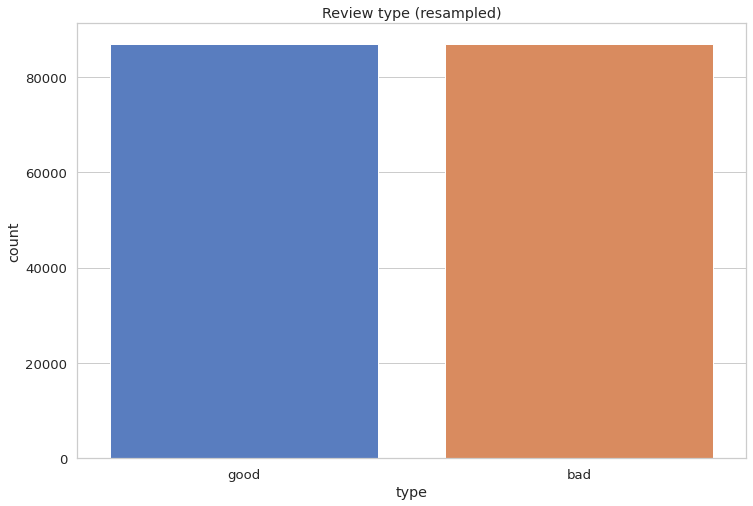

In [ ]:
sns.countplot(
  x='review_type',
  data=df_review_resampled,
  order=df_review_resampled.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

## Data Preparation

In [ ]:
df_review_resampled.review_type.to_numpy().reshape(-1, 1)

array([['good'],
       ['good'],
       ['good'],
       ...,
       ['bad'],
       ['bad'],
       ['bad']], dtype=object)

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_review = one_hot_encoder.fit_transform(df_review_resampled.review_type.to_numpy().reshape(-1, 1))

### Train/test Split

In [ ]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_review_resampled.review, 
    encoded_review, 
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

### Generate Embedding

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 130276/130276 [1:12:40<00:00, 29.88it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 43426/43426 [24:38<00:00, 29.38it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(130276, 512) (43426, 512)


In [ ]:
print(y_train.shape, y_test.shape)

(130276, 2) (43426, 2)


# Sentiment Analysis Modeling

## Utility Function

In [ ]:
# plot accuracy and loss
def plot_history(history):
  accuracy = history.history['accuracy']
  val_accuracy= history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# plot model architecture
def plot_model(model):
  model.summary()
  return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

## Baseline NN Model

In [ ]:
def build_model_1():
  model = Sequential()
  model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.001))
  return model

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


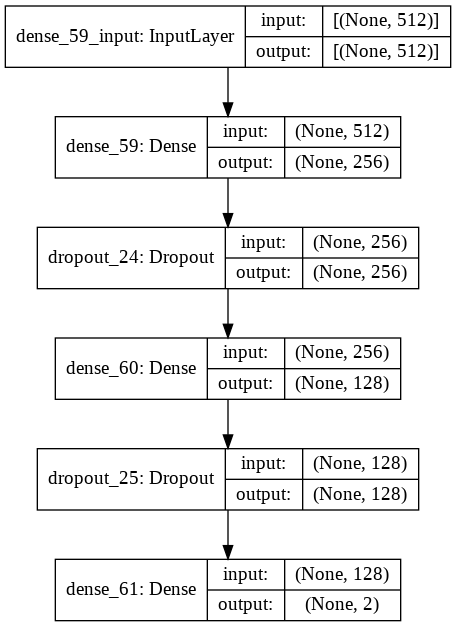

In [ ]:
model_1 = build_model_1()
plot_model(model_1)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7328/7328 [==============================] - 23s 3ms/step - loss: 0.4304 - accuracy: 0.7966 - val_loss: 0.4168 - val_accuracy: 0.8062
Epoch 2/10
7328/7328 [==============================] - 23s 3ms/step - loss: 0.4070 - accuracy: 0.8120 - val_loss: 0.4048 - val_accuracy: 0.8095
Epoch 3/10
7328/7328 [==============================] - 22s 3ms/step - loss: 0.3945 - accuracy: 0.8182 - val_loss: 0.4061 - val_accuracy: 0.8145
Epoch 4/10
7328/7328 [==============================] - 23s 3ms/step - loss: 0.3826 - accuracy: 0.8247 - val_loss: 0.3981 - val_accuracy: 0.8165
Epoch 5/10
7328/7328 [==============================] - 23s 3ms/step - loss: 0.3703 - accuracy: 0.8302 - val_loss: 0.4011 - val_accuracy: 0.8214
Epoch 6/10
7328/7328 [==============================] - 23s 3ms/step - loss: 0.3598 - accuracy: 0.8360 - val_loss: 0.4007 - val_accuracy: 0.8166
Epoch 7/10
7328/7328 [==============================] - 24s 3ms/step - loss: 0.3483 - accuracy: 0.8421 - val_loss: 0.4045 - val_ac

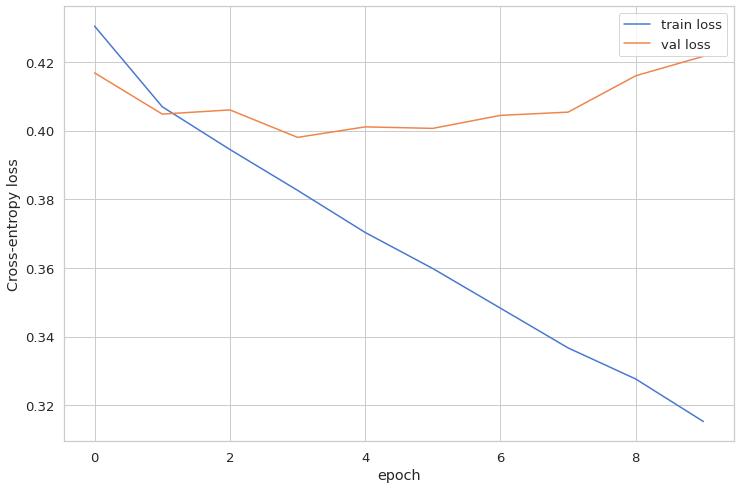

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

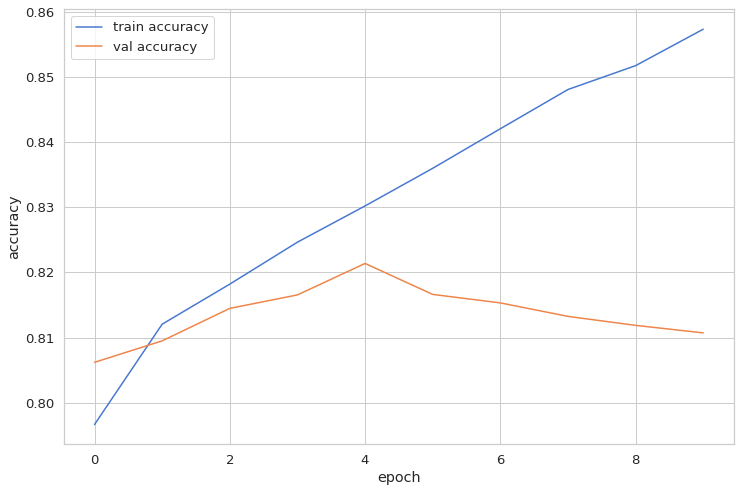

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

1358/1358 [==============================] - 4s 3ms/step - loss: 0.4358 - accuracy: 0.8080


[0.4358104467391968, 0.8080412745475769]

### Prediction

In [ ]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

 Location staff  Asked for late checkout and didnt get an answer then got a yes but had to pay 25 euros by noon they called to say sorry you have to leave in 1h knowing that i had a sick dog and an appointment next to the hotel 
Bad


In [ ]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.96194005 0.03805996]]


'Bad'

In [ ]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

 Easy to find Easy location No traffic noise in room  Flooded bathroom from room above Painting and decorating blocking stair access 
Bad


In [ ]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.57938844 0.4206116 ]]


'Bad'

## LSTM Model

For an LSTM layer, you need the shape like  `(NumberOfExamples, TimeSteps, FeaturesPerStep)`

In [ ]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]
y_train_reshaped = y_train[:, newaxis, :]
y_test_reshaped = y_test[:, newaxis, :]

In [ ]:
y_train_reshaped.shape

(130276, 1, 2)

In [ ]:
(1,X_train_reshaped.shape[2])

(1, 512)

In [ ]:
def build_model_lstm():
  model = Sequential()
  model.add(LSTM(256, activation='sigmoid', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))

  model.add(Dense(128, activation='relu'))

  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 256)            787456    
_________________________________________________________________
dense_62 (Dense)             (None, 1, 128)            32896     
_________________________________________________________________
dense_63 (Dense)             (None, 1, 2)              258       
Total params: 820,610
Trainable params: 820,610
Non-trainable params: 0
_________________________________________________________________


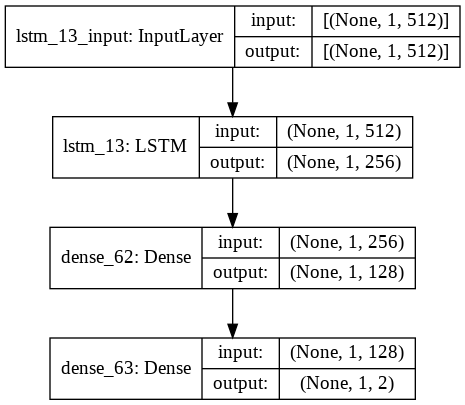

In [ ]:
model_lstm_1 = build_model_lstm()
plot_model(model_lstm_1)

In [ ]:
history_lstm_1 = model_lstm_1.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7328/7328 [==============================] - 37s 5ms/step - loss: 0.4493 - accuracy: 0.7860 - val_loss: 0.4312 - val_accuracy: 0.7949
Epoch 2/10
7328/7328 [==============================] - 35s 5ms/step - loss: 0.4231 - accuracy: 0.7986 - val_loss: 0.4313 - val_accuracy: 0.7918
Epoch 3/10
7328/7328 [==============================] - 35s 5ms/step - loss: 0.4176 - accuracy: 0.8009 - val_loss: 0.4159 - val_accuracy: 0.8032
Epoch 4/10
7328/7328 [==============================] - 35s 5ms/step - loss: 0.4141 - accuracy: 0.8038 - val_loss: 0.4175 - val_accuracy: 0.7997
Epoch 5/10
7328/7328 [==============================] - 35s 5ms/step - loss: 0.4121 - accuracy: 0.8047 - val_loss: 0.4169 - val_accuracy: 0.8037
Epoch 6/10
7328/7328 [==============================] - 35s 5ms/step - loss: 0.4106 - accuracy: 0.8061 - val_loss: 0.4142 - val_accuracy: 0.8054
Epoch 7/10
7328/7328 [==============================] - 36s 5ms/step - loss: 0.4087 - accuracy: 0.8078 - val_loss: 0.4187 - val_ac

In [ ]:
model_lstm_1.evaluate(X_test_reshaped, y_test_reshaped)

1358/1358 [==============================] - 6s 4ms/step - loss: 0.4151 - accuracy: 0.8023


[0.41513755917549133, 0.8022612929344177]

In [ ]:
plot_history(history_lstm_1)

In [ ]:
def build_model_lstm_2():
  model = Sequential()

  model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
  model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))

  model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))

  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 256)            787456    
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 128)            197120    
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 64)             49408     
_________________________________________________________________
dense_64 (Dense)             (None, 1, 2)              130       
Total params: 1,034,114
Trainable params: 1,034,114
Non-trainable params: 0
_________________________________________________________________


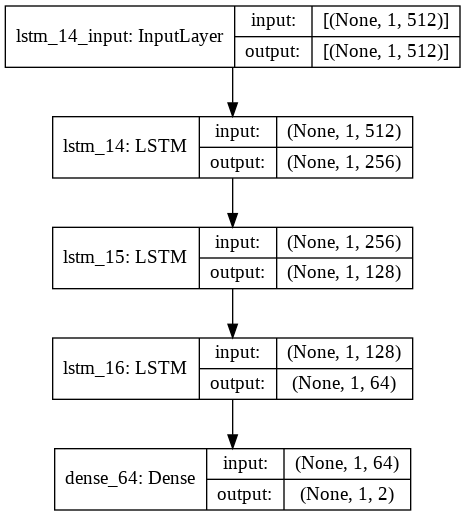

In [ ]:
model_lstm_2 = build_model_lstm_2()
plot_model(model_lstm_2)

In [ ]:
history = model_lstm_2.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7328/7328 [==============================] - 67s 9ms/step - loss: 0.4321 - accuracy: 0.7938 - val_loss: 0.4140 - val_accuracy: 0.8059
Epoch 2/10
7328/7328 [==============================] - 64s 9ms/step - loss: 0.4066 - accuracy: 0.8103 - val_loss: 0.4134 - val_accuracy: 0.8087
Epoch 3/10
7328/7328 [==============================] - 64s 9ms/step - loss: 0.3942 - accuracy: 0.8180 - val_loss: 0.4007 - val_accuracy: 0.8138
Epoch 4/10
7328/7328 [==============================] - 64s 9ms/step - loss: 0.3835 - accuracy: 0.8246 - val_loss: 0.3957 - val_accuracy: 0.8140
Epoch 5/10
7328/7328 [==============================] - 64s 9ms/step - loss: 0.3723 - accuracy: 0.8311 - val_loss: 0.4004 - val_accuracy: 0.8116
Epoch 6/10
7328/7328 [==============================] - 65s 9ms/step - loss: 0.3619 - accuracy: 0.8374 - val_loss: 0.3958 - val_accuracy: 0.8133
Epoch 7/10
7328/7328 [==============================] - 64s 9ms/step - loss: 0.3504 - accuracy: 0.8440 - val_loss: 0.3945 - val_ac

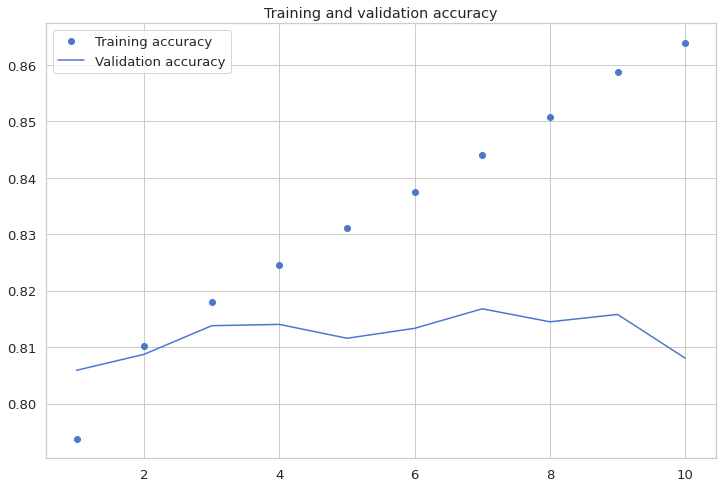

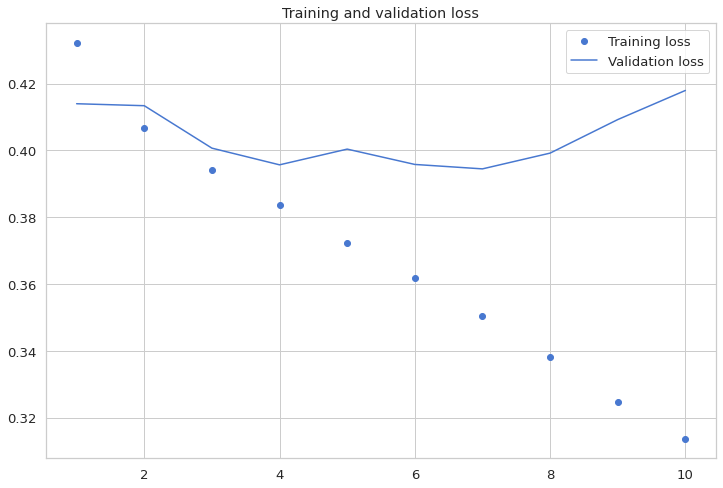

In [ ]:
plot_history(history)

In [ ]:
model_lstm_2.evaluate(X_test_reshaped, y_test_reshaped)

1358/1358 [==============================] - 6s 4ms/step - loss: 0.4256 - accuracy: 0.8091


[0.4256402552127838, 0.8090775012969971]

## Serve Model

### Save Model

In [ ]:
model_lstm_2.save("lstm_final_model.h5")

### Load Model

In [11]:
imported_model = tf.keras.models.load_model('/content/lstm_final_model.h5')
imported_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 256)            787456    
                                                                 
 lstm_11 (LSTM)              (None, 1, 128)            197120    
                                                                 
 lstm_12 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dense_28 (Dense)            (None, 1, 2)              130       
                                                                 
Total params: 1,034,114
Trainable params: 1,034,114
Non-trainable params: 0
_________________________________________________________________


### Prediction

#### Positive Sentiment

In [28]:
text = 'This room is great'
emb_test = use(text)
emb_test.shape

TensorShape([1, 512])

In [29]:
emb_test_reshaped = emb_test[:, newaxis, :]
emb_test_reshaped.shape

TensorShape([1, 1, 512])

In [30]:
imported_model.predict(emb_test_reshaped)

array([[[0.25375777, 0.7462422 ]]], dtype=float32)

In [31]:
sentimen_val = np.argmax(imported_model.predict(emb_test_reshaped))

"Good" if sentimen_val == 1 else "Bad"

'Good'

#### Negative Sentiment

In [32]:
text = 'This room is small'
emb_test = use(text)

emb_test_reshaped = emb_test[:, newaxis, :]
emb_test_reshaped.shape

imported_model.predict(emb_test_reshaped)

array([[[0.8195092 , 0.18049078]]], dtype=float32)

In [33]:
sentimen_val = np.argmax(imported_model.predict(emb_test_reshaped))

"Good" if sentimen_val == 1 else "Bad"

'Bad'

### Prediction Pipeline

In [38]:
def predict_sentiment(txt):
  emb_txt = use(txt)
  emb_test_reshaped = emb_txt[:, newaxis, :]
  sentiment_val = np.argmax(imported_model.predict(emb_test_reshaped))
  return "Positive" if sentiment_val == 1 else "Negative"

In [39]:
sample_text = "I like the room service"
f"The sentiment of this sentence is : {predict_sentiment(sample_text)}"

'The sentiment of this sentence is : Positive'

In [48]:
sample_text = "The windows is so big. it has good air circulation"
f"The sentiment of this sentence is : {predict_sentiment(sample_text)}"

'The sentiment of this sentence is : Positive'